<a href="https://colab.research.google.com/github/nataliakotsani/Singing-Voice-Multi-Sensor-Analysis/blob/main/svmsat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTS

In [ ]:
!pip install pydub
!pip install praat-parselmouth
import parselmouth
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
import pandas as pd
from pydub import AudioSegment
import seaborn as sns
from scipy import signal as sg
from scipy.io import wavfile
import math

     |████████████████████████████████| 10.7 MB 5.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


AUDIO SAMPLES SLICING

In [ ]:
i = 0
du = 20
j=0
for filename in os.listdir(os.path.join('/DATASET/AUDIO')):
    if filename != '.DS_Store':
      song  =  os.path.join('/DATASET/AUDIO',f'{filename}')
      j = j+1
      for w in range(0,151):
        i = i+1
        t1 = du*(w)*1000
        t2 = du*(w+1)*1000
        newAudio = AudioSegment.from_file(song)
        new = newAudio[t1:t2]
        print(new.duration_seconds)
        if new.duration_seconds == du:
          new.export(f'/DATASET/AUDIO/2sec/{str(w)}.wav', format="wav")


MS TO PITCH

In [ ]:
threshold = 80
i=0
MIC_PITCH = []
for filename in os.listdir(os.path.join('/DATASET/MIC/')):
    if filename != '.DS_Store':
      snd = parselmouth.Sound('/DATASET/MIC/' + str(i) +'.wav')
      pitch = snd.to_pitch()
      pitch_values = pitch.selected_array['frequency']
      MIC_PITCH.append(np.mean(pitch_values[pitch_values>threshold]))
      i=i+1

EGG TO PITCH

In [ ]:
threshold = 80
i=0
EGG_PITCH = []
for filename in os.listdir(os.path.join('/DATASET/EGG/')):
    if filename != '.DS_Store':
      snd = parselmouth.Sound('/DATASET/EGG/' + str(i) +'.wav')
      pitch = snd.to_pitch()
      pitch_values = pitch.selected_array['frequency']
      EGG_PITCH.append(np.mean(pitch_values[pitch_values>threshold]))
      i=i+1

MIC TO EGG SUBTRACT

In [ ]:
import numpy as np
np.set_printoptions(suppress=True)
SUB_PITCH = []
decimals = 4

EGG_PITCH_NP = np.array(EGG_PITCH)
EGG_PITCH_NP = np.around(EGG_PITCH_NP,decimals)

MIC_PITCH_NP = np.array(MIC_PITCH)
MIC_PITCH_NP = np.around(MIC_PITCH_NP,decimals)

SUB_PITCH_NP = np.array(SUB_PITCH)

SUB_PITCH_NP = MIC_PITCH_NP - EGG_PITCH_NP
SUB_PITCH_NP = np.around(SUB_PITCH_NP,decimals)

SUB = SUB_PITCH_NP

CONVERT TO MEL SCALE

In [ ]:
decimals = 4
MEL_MIC_PITCH_NP = np.zeros(456)
MEL_EGG_PITCH_NP = np.zeros(456)
MEL_SUB_PITCH_NP = np.zeros(456)

for i in range (0, 456):
  MEL_MIC_PITCH_NP[i] = 1127 * math.log(1 + (MIC_PITCH_NP[i]/700))
  MEL_EGG_PITCH_NP[i] = 1127 * math.log(1 + (EGG_PITCH_NP[i]/700))

MEL_SUB_PITCH_NP = MEL_MIC_PITCH_NP - MEL_EGG_PITCH_NP
MEL_SUB_PITCH_NP = np.around(MEL_SUB_PITCH_NP,decimals)

IMPORT BREATHINESS RATINGS

In [ ]:
br_eval_df = pd.read_csv('/DATASET/breathiness.csv')
BR_EVAL = br_eval_df.to_numpy()
BR_EVAL = BR_EVAL.flatten()

# COMPARISON

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
COMP = np.zeros((456, 6))

for i in range (0, 456):
  COMP[i][0]=i
  COMP[i][1]=MIC_PITCH_NP[i]
  COMP[i][2]=EGG_PITCH_NP[i]
  COMP[i][3]=SUB_PITCH_NP[i]
  COMP[i][4]=abs(SUB_PITCH_NP[i])
  COMP[i][5]=BR_EVAL[i]

print(COMP)

[[   0.      181.8027  181.7826    0.0201    0.0201    0.75  ]
 [   1.      180.9253  180.9227    0.0026    0.0026    0.5   ]
 [   2.      180.2598  180.2467    0.0131    0.0131    0.25  ]
 [   3.      180.0371  180.0327    0.0044    0.0044    0.5   ]
 [   4.      179.8933  179.8877    0.0056    0.0056    0.25  ]
 [   5.      180.7231  180.7223    0.0008    0.0008    0.25  ]
 [   6.      180.5152  180.5319   -0.0167    0.0167    0.5   ]
 [   7.      180.0549  180.0515    0.0034    0.0034    0.    ]
 [   8.      180.2214  180.2191    0.0023    0.0023    1.25  ]
 [   9.      180.5966  180.5889    0.0077    0.0077    1.25  ]
 [  10.      180.1621  180.1571    0.005     0.005     1.25  ]
 [  11.      180.6477  180.6435    0.0042    0.0042    1.25  ]
 [  12.      180.3547  180.3452    0.0095    0.0095    1.75  ]
 [  13.      180.3466  180.3318    0.0148    0.0148    1.    ]
 [  14.      184.6142  184.6097    0.0045    0.0045    2.25  ]
 [  15.      183.7066  183.7082   -0.0016    0.0016    

IMPORT OQ VALUES

In [ ]:
oq_all_df = pd.read_csv('/DATASET/OQ_ALL.csv')
OQ_ALL = oq_all_df.to_numpy()
DOQ = np.zeros(456)
HOQ = np.zeros(456)
DOQ_COUNT = np.zeros(456)
for i in range (0, 203089):
  ind = OQ_ALL[i][0]
  DOQ[ind] = DOQ[ind] + OQ_ALL[i][7]
  HOQ[ind] = HOQ[ind] + OQ_ALL[i][8]
  DOQ_COUNT[ind] = DOQ_COUNT[ind] + 1
for j in range (0, 456):
  DOQ[j] = DOQ[j]/DOQ_COUNT[j]
  HOQ[j] = HOQ[j]/DOQ_COUNT[j]

IMPORT ABI VALUES

In [ ]:
abi_df = pd.read_csv('/DATASET/abi.csv')
ABI = abi_df.to_numpy()
ABI = ABI.flatten()

IMPORT CPP VALUES

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
cpp_eval_df = pd.read_csv('/DATASET/CPPs.csv')
CPP_EVAL = cpp_eval_df.to_numpy()
CPP_EVAL = CPP_EVAL.flatten()

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
cpp_egg_eval_df = pd.read_csv('/DATASET/CPPs-EGG.csv')
CPP_EGG_EVAL = cpp_egg_eval_df.to_numpy()
CPP_EGG_EVAL = CPP_EGG_EVAL.flatten()

ALL VALUES

In [ ]:
COMP = np.zeros((456, 14))
for i in range (0, 456):
  COMP[i][0]=i
  COMP[i][1]=MIC_PITCH_NP[i]
  COMP[i][2]=EGG_PITCH_NP[i]
  COMP[i][3]=SUB_PITCH_NP[i]
  COMP[i][4]=abs(SUB_PITCH_NP[i])
  COMP[i][5]=BR_EVAL[i]
  COMP[i][6]=CPP_EVAL[i]
  COMP[i][7]=CPP_EGG_EVAL[i]
  COMP[i][8]=DOQ[i]
  COMP[i][9]=HOQ[i]
  COMP[i][10]=MEL_MIC_PITCH_NP[i]
  COMP[i][11]=MEL_EGG_PITCH_NP[i]
  COMP[i][12]=MEL_SUB_PITCH_NP[i]
  COMP[i][13]=ABI[i]

ALL PLOTS

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
findfont: Font family ['STIX General'] not found. Falling back to DejaVu Sans.


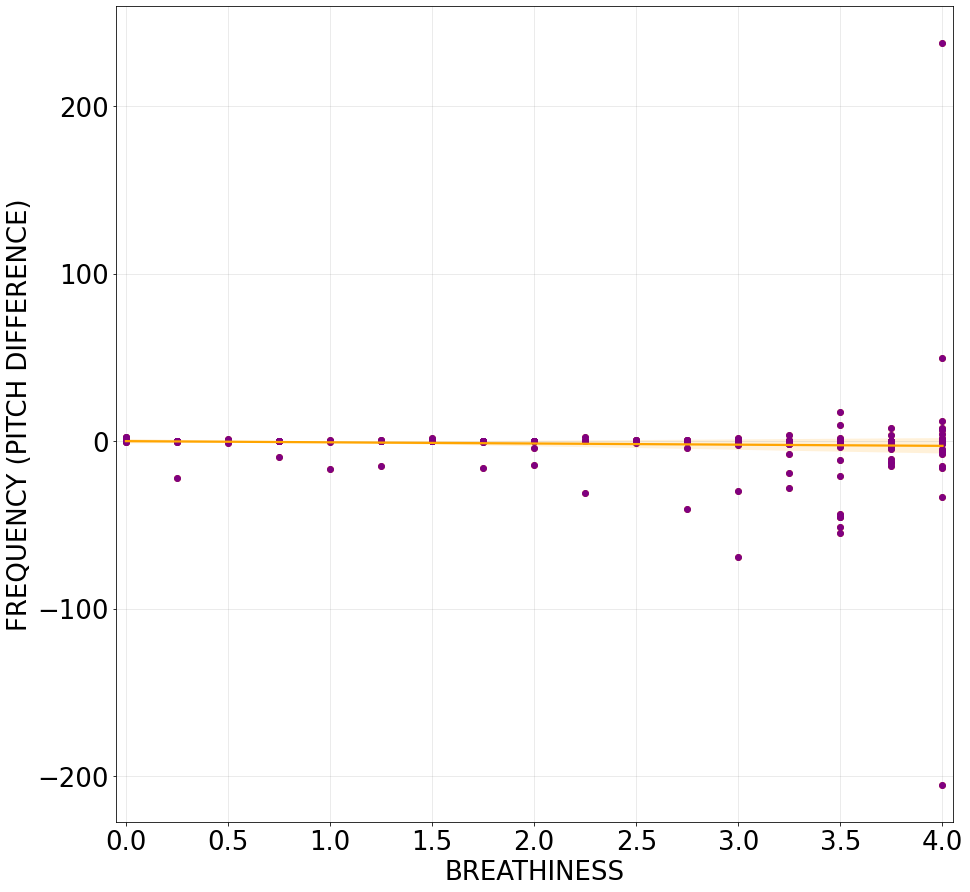

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


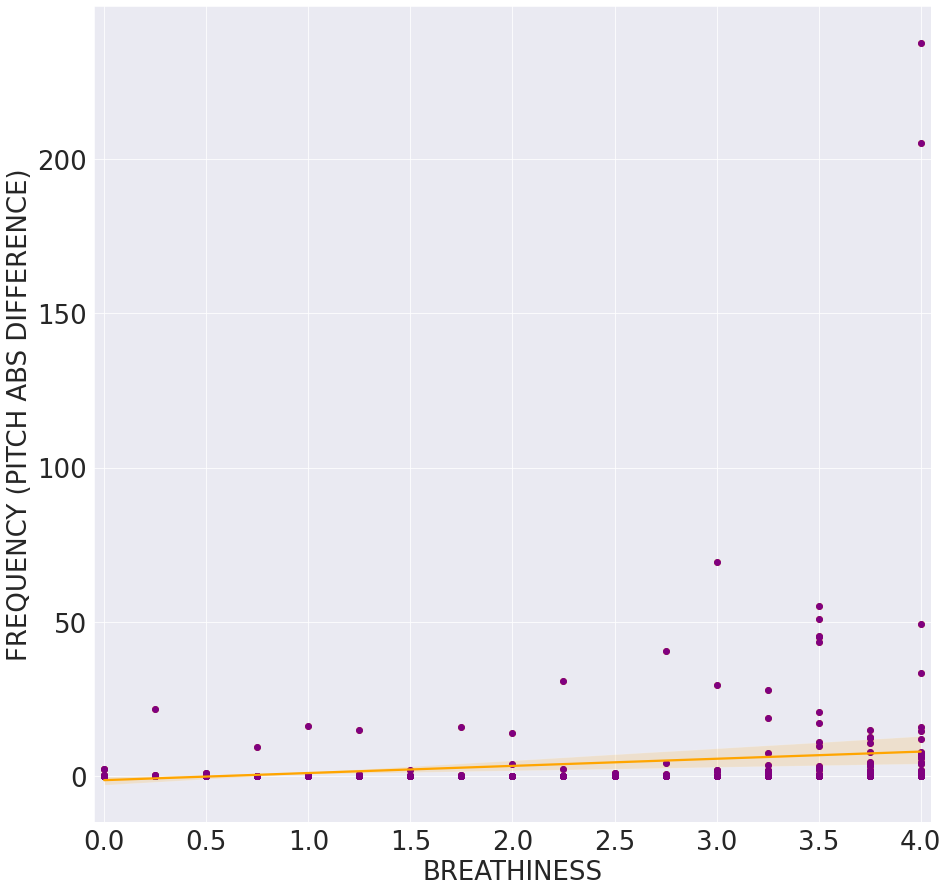

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


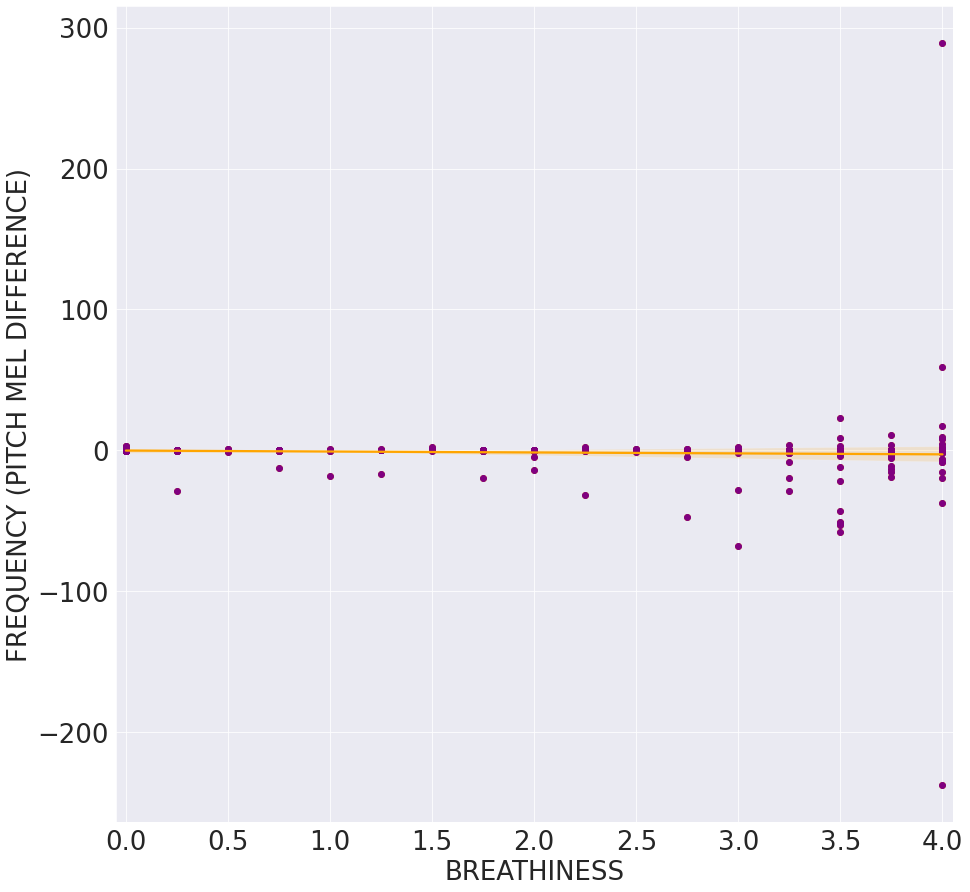

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


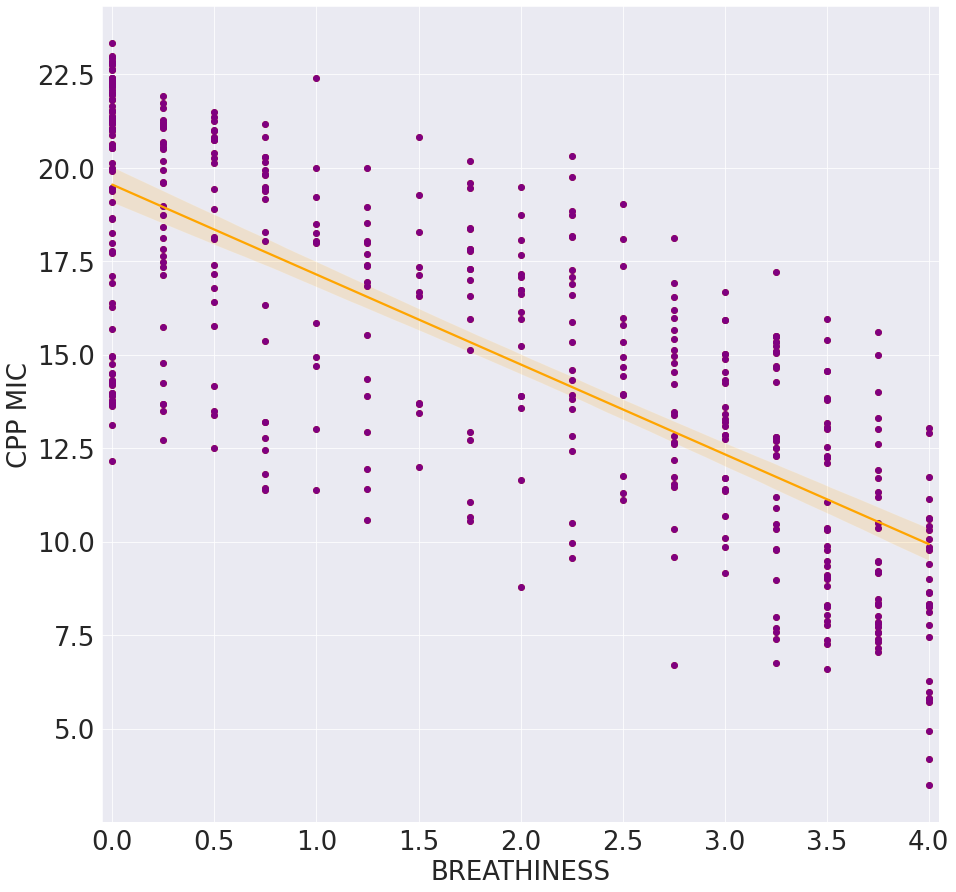

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


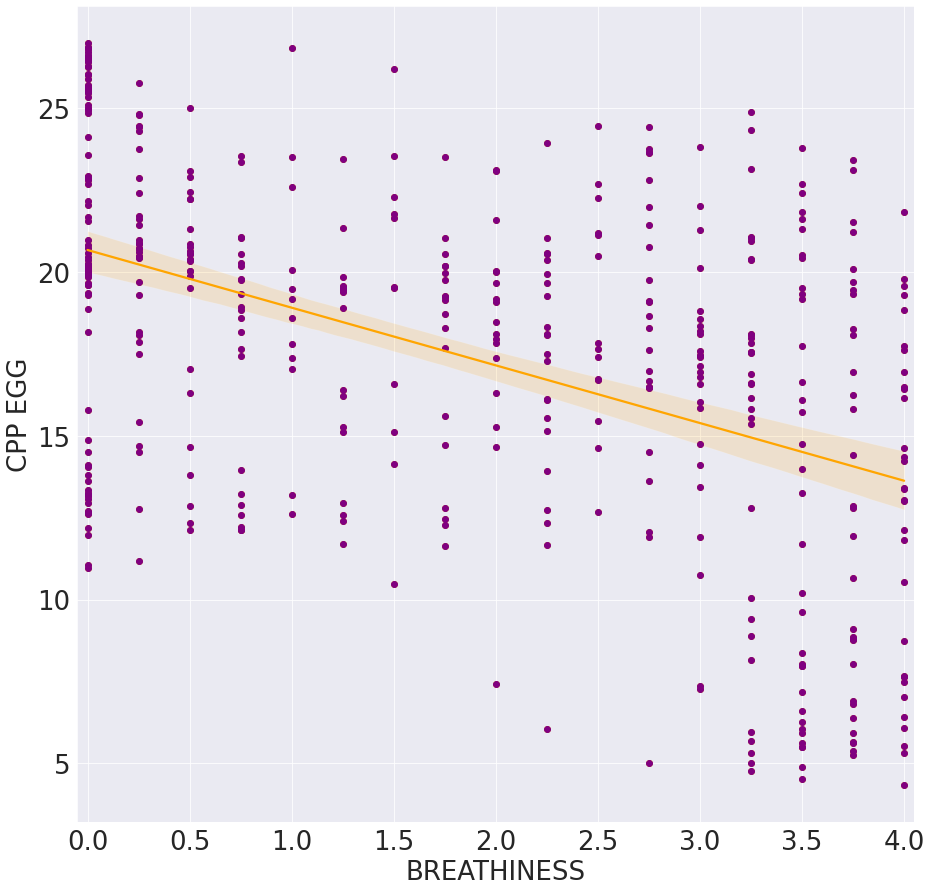

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


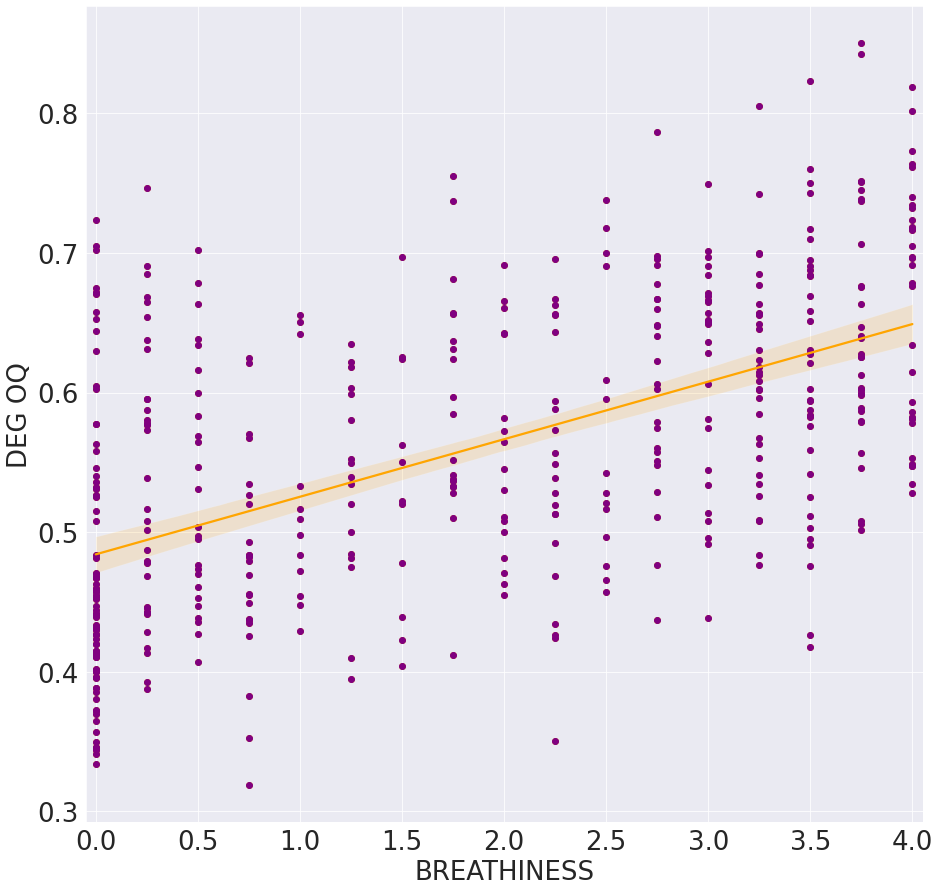

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


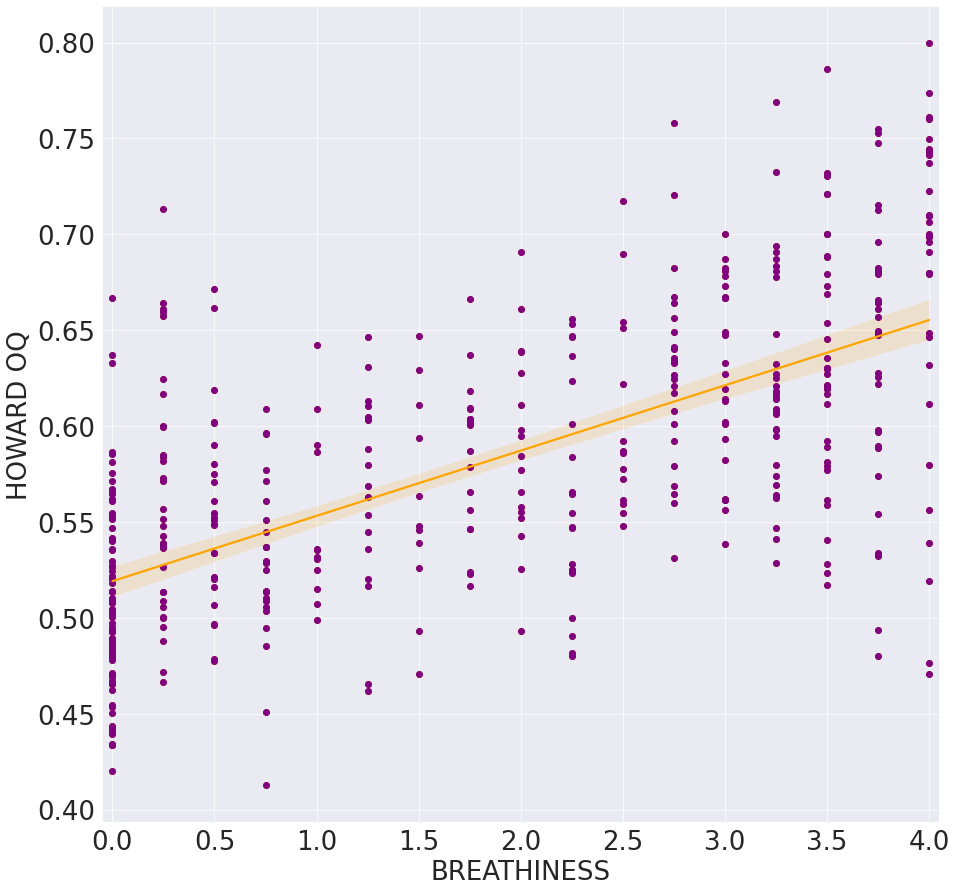

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


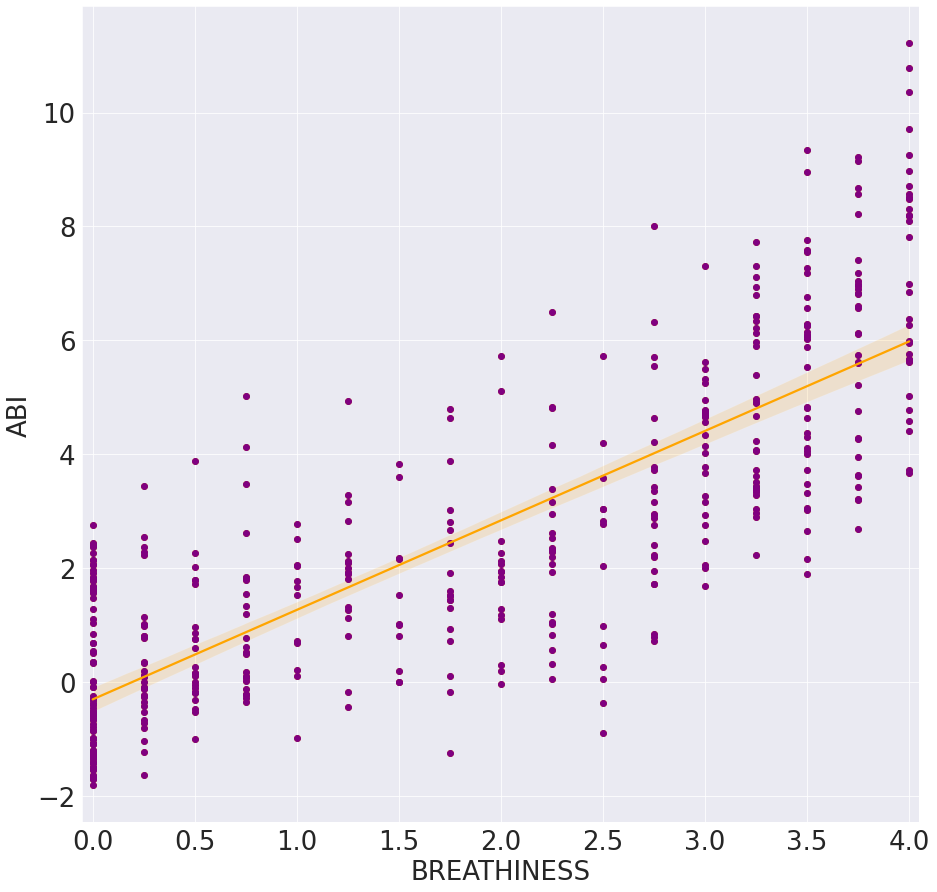

In [ ]:
plt.rcParams.update({'font.size': 26})
plt.rcParams.update({'font.family': 'STIX General'})
import seaborn as sns
xliml = -0.05
xlimr = 4.05

# PITCH DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,3]
plt.figure(figsize=(15,15))
plt.plot(x, y, "o", color = 'purple')
sns.regplot(x, y, color = 'orange')
sns.set_style("darkgrid")
plt.grid(color = 'grey', linestyle = '-', alpha=0.3, linewidth = 0.5)
plt.xlim(xliml, xlimr)
plt.ylabel("FREQUENCY (PITCH DIFFERENCE)")
plt.xlabel("BREATHINESS")
plt.show()

# PITCH ABS DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,4]
plt.figure(figsize=(15,15))
plt.plot(x, y, "o", color = 'purple')
sns.regplot(x, y, color = 'orange')
plt.xlim(xliml, xlimr)
plt.ylabel("FREQUENCY (PITCH ABS DIFFERENCE)")
plt.xlabel("BREATHINESS")
plt.show()

# PITCH DIFFS MEL / BREATHINESS
x = COMP[:,5]
y = COMP[:,12]
plt.figure(figsize=(15,15))
plt.plot(x, y, "o", color = 'purple')
sns.regplot(x, y, color = 'orange')
plt.xlim(xliml, xlimr)
plt.ylabel("FREQUENCY (PITCH MEL DIFFERENCE)")
plt.xlabel("BREATHINESS")
plt.show()

# PITCH CPP MIC / BREATHINESS
x = COMP[:,5]
y = COMP[:,6]
plt.figure(figsize=(15,15))
plt.plot(x, y, "o", color = 'purple')
sns.regplot(x, y, color = 'orange')
plt.xlim(xliml, xlimr)
plt.ylabel("CPP MIC")
plt.xlabel("BREATHINESS")
plt.show()

# PITCH CPP EGG / BREATHINESS
x = COMP[:,5]
y = COMP[:,7]
plt.figure(figsize=(15,15))
plt.plot(x, y, "o", color = 'purple')
sns.regplot(x, y, color = 'orange')
plt.xlim(xliml, xlimr)
plt.ylabel("CPP EGG")
plt.xlabel("BREATHINESS")
plt.show()

# DEGG OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,8]
plt.figure(figsize=(15,15))
plt.plot(x, y, "o", color = 'purple')
sns.regplot(x, y, color = 'orange')
plt.xlim(xliml, xlimr)
plt.ylabel("DEG OQ")
plt.xlabel("BREATHINESS")
plt.show()

# HOWARD OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,9]
plt.figure(figsize=(15,15))
plt.plot(x, y, "o", color = 'purple')
sns.regplot(x, y, color = 'orange')
plt.xlim(xliml, xlimr)
plt.ylabel("HOWARD OQ")
plt.xlabel("BREATHINESS")
plt.show()

# ABI / BREATHINESS
x = COMP[:,5]
y = COMP[:,13]
plt.figure(figsize=(15,15))
plt.plot(x, y, "o", color = 'purple')
sns.regplot(x, y, color = 'orange')
plt.xlim(xliml, xlimr)
plt.ylabel("ABI")
plt.xlabel("BREATHINESS")
plt.show()

Pearson Correlation Coefficient

In [ ]:
from scipy import stats
dec = 10

print('___________________________________')
print('Pearson Correlation Coefficients')

# PITCH DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,3]

my_rho = stats.pearsonr(x, y)
print('DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('DIFS / BREATHINESS p = ', round(my_rho[1], dec))


# PITCH ABS DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,4]
my_rho = stats.pearsonr(x, y)
print('ABS DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABS DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH DIFFS MEL / BREATHINESS
x = COMP[:,5]
y = COMP[:,12]
my_rho = stats.pearsonr(x, y)
print('MEL DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('MEL DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP MIC / BREATHINESS
x = COMP[:,5]
y = COMP[:,6]
my_rho = stats.pearsonr(x, y)
print('CPP MIC / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP MIC / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP EGG / BREATHINESS
x = COMP[:,5]
y = COMP[:,7]
my_rho = stats.pearsonr(x, y)
print('CPP EGG / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP EGG / BREATHINESS p = ', round(my_rho[1], dec))

# DEGG OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,8]
my_rho = stats.pearsonr(x, y)
print('DEG OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('DEG OQ / BREATHINESS p = ', round(my_rho[1], dec))

# HOWARD OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,9]
my_rho = stats.pearsonr(x, y)
print('HOWARD OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('HOWARD OQ / BREATHINESS p = ', round(my_rho[1], dec))

# ABI / BREATHINESS
x = COMP[:,5]
y = COMP[:,13]
my_rho = stats.pearsonr(x, y)
print('ABI / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABI / BREATHINESS p = ', round(my_rho[1], dec))

print('')
print('___________________________________')
print('')

print('___________________________________')
print('Spearman Correlation Coefficients')

# PITCH DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,3]
my_rho = stats.spearmanr(x, y)
#print('DIFS / BREATHINESS cor = ', my_rho)
print('DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH ABS DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,4]
my_rho = stats.spearmanr(x, y)
print('ABS DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABS DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH DIFFS MEL / BREATHINESS
x = COMP[:,5]
y = COMP[:,12]
my_rho = stats.spearmanr(x, y)
print('MEL DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('MEL DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP MIC / BREATHINESS
x = COMP[:,5]
y = COMP[:,6]
my_rho = stats.spearmanr(x, y)
print('CPP MIC / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP MIC / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP EGG / BREATHINESS
x = COMP[:,5]
y = COMP[:,7]
my_rho = stats.spearmanr(x, y)
print('CPP EGG / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP EGG / BREATHINESS p = ', round(my_rho[1], dec))

# DEGG OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,8]
my_rho = stats.spearmanr(x, y)
print('DEG OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('DEG OQ / BREATHINESS p = ', round(my_rho[1], dec))

# HOWARD OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,9]
my_rho = stats.spearmanr(x, y)
print('HOWARD OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('HOWARD OQ / BREATHINESS p = ', round(my_rho[1], dec))

# ABI / BREATHINESS
x = COMP[:,5]
y = COMP[:,13]
my_rho = stats.spearmanr(x, y)
print('ABI / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABI OQ / BREATHINESS p = ', round(my_rho[1], dec))

print('')
print('___________________________________')
print('')

print('MEANS')
column_means = COMP.mean(axis=0)

print("MIC PITCH")
print(column_means[1])

print("MEL MIC PITCH")
print(column_means[10])

print("EGG PITCH")
print(column_means[2])

print("MEL EGG PITCH")
print(column_means[11])

print("SUB PITCH")
print(column_means[3])

print("MEL SUB PITCH")
print(column_means[12])

print("ABS SUB PITCH")
print(column_means[4])

print("BR EVAL")
print(column_means[5])

print("CPP EVAL")
print(column_means[6])

print("CPP EGG EVAL")
print(column_means[7])

print("DEGOQ")
print(column_means[8])

print("HOQ")
print(column_means[9])

print('')
print('___________________________________')
print('')

print('CLASSES (<=0.75, <=1.5, <=2.25, <=3.25, <=4)')

l = COMP.shape[0]
c = COMP.shape[1]
SUMS = np.zeros((5, c))
count0 = 0
count1 = 0
count2 = 0
count3 = 0
count4 = 0

for i in range (0, l):
    if (COMP[i][5] < 0.75):
      SUMS[0][0] = SUMS[0][0] + 1
      SUMS[0][1:] = SUMS[0][1:] + COMP[i][1:]
    elif (COMP[i][5] <= 1.5):
      SUMS[1][0] = SUMS[1][0] + 1
      SUMS[1][1:] = SUMS[1][1:] + COMP[i][1:]
    elif (COMP[i][5] <= 2.25):
      SUMS[2][0] = SUMS[2][0] + 1
      SUMS[2][1:] = SUMS[2][1:] + COMP[i][1:]
    elif (COMP[i][5] <= 3.25):
      SUMS[3][0] = SUMS[3][0] + 1
      SUMS[3][1:] = SUMS[3][1:] + COMP[i][1:]
    else:
      SUMS[4][0] = SUMS[4][0] + 1
      SUMS[4][1:] = SUMS[4][1:] + COMP[i][1:]

print('SUM VALUES')
print(SUMS)
print('SAMLES: ', l)

print('')
print('___________________________________')
print('')

print('MEAN VALUES')
MEAN = np.zeros((5, c))
for m in range (1, c):
  MEAN[0][m] = SUMS[0][m]/SUMS[0][0]
  MEAN[1][m] = SUMS[1][m]/SUMS[1][0]
  MEAN[2][m] = SUMS[2][m]/SUMS[2][0]
  MEAN[3][m] = SUMS[3][m]/SUMS[3][0]
  MEAN[4][m] = SUMS[4][m]/SUMS[4][0]
print(MEAN)

print('')
print('___________________________________')
print('')



___________________________________
Pearson Correlation Coefficients
DIFS / BREATHINESS cor =  -0.0605840353
DIFS / BREATHINESS p =  0.1965800696
ABS DIFS / BREATHINESS cor =  0.2019937871
ABS DIFS / BREATHINESS p =  1.38358e-05
MEL DIFS / BREATHINESS cor =  -0.0493798921
MEL DIFS / BREATHINESS p =  0.2927014889
CPP MIC / BREATHINESS cor =  -0.7655307807
CPP MIC / BREATHINESS p =  0.0
CPP EGG / BREATHINESS cor =  -0.4701202048
CPP EGG / BREATHINESS p =  0.0
DEG OQ / BREATHINESS cor =  0.5516069621
DEG OQ / BREATHINESS p =  0.0
HOWARD OQ / BREATHINESS cor =  0.6422739617
HOWARD OQ / BREATHINESS p =  0.0
ABI / BREATHINESS cor =  0.8107445184
ABI / BREATHINESS p =  0.0

___________________________________

___________________________________
Spearman Correlation Coefficients
DIFS / BREATHINESS cor =  -0.1436305909
DIFS / BREATHINESS p =  0.0021075073
ABS DIFS / BREATHINESS cor =  0.4405220831
ABS DIFS / BREATHINESS p =  0.0
MEL DIFS / BREATHINESS cor =  -0.1426754039
MEL DIFS / BREATHINES

CORRELATIONS ROUND

In [ ]:
from scipy import stats
dec = 4

print('___________________________________')
print('Pearson Correlation Coefficients')

# PITCH DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,3]

#my_rho = np.corrcoef(x, y)
my_rho = stats.pearsonr(x, y)
#print('DIFS / BREATHINESS cor = ', my_rho)
print('DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('DIFS / BREATHINESS p = ', round(my_rho[1], dec))


# PITCH ABS DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,4]
my_rho = stats.pearsonr(x, y)
print('ABS DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABS DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH DIFFS MEL / BREATHINESS
x = COMP[:,5]
y = COMP[:,12]
my_rho = stats.pearsonr(x, y)
print('MEL DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('MEL DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP MIC / BREATHINESS
x = COMP[:,5]
y = COMP[:,6]
my_rho = stats.pearsonr(x, y)
print('CPP MIC / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP MIC / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP EGG / BREATHINESS
x = COMP[:,5]
y = COMP[:,7]
my_rho = stats.pearsonr(x, y)
print('CPP EGG / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP EGG / BREATHINESS p = ', round(my_rho[1], dec))

# DEGG OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,8]
my_rho = stats.pearsonr(x, y)
print('DEG OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('DEG OQ / BREATHINESS p = ', round(my_rho[1], dec))

# HOWARD OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,9]
my_rho = stats.pearsonr(x, y)
print('HOWARD OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('HOWARD OQ / BREATHINESS p = ', round(my_rho[1], dec))

# ABI / BREATHINESS
x = COMP[:,5]
y = COMP[:,13]
my_rho = stats.pearsonr(x, y)
print('ABI / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABI / BREATHINESS p = ', round(my_rho[1], dec))

print('')
print('___________________________________')
print('')

print('___________________________________')
print('Spearman Correlation Coefficients')

# PITCH DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,3]
my_rho = stats.spearmanr(x, y)
#print('DIFS / BREATHINESS cor = ', my_rho)
print('DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH ABS DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,4]
my_rho = stats.spearmanr(x, y)
print('ABS DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABS DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH DIFFS MEL / BREATHINESS
x = COMP[:,5]
y = COMP[:,12]
my_rho = stats.spearmanr(x, y)
print('MEL DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('MEL DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP MIC / BREATHINESS
x = COMP[:,5]
y = COMP[:,6]
my_rho = stats.spearmanr(x, y)
print('CPP MIC / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP MIC / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP EGG / BREATHINESS
x = COMP[:,5]
y = COMP[:,7]
my_rho = stats.spearmanr(x, y)
print('CPP EGG / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP EGG / BREATHINESS p = ', round(my_rho[1], dec))

# DEGG OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,8]
my_rho = stats.spearmanr(x, y)
print('DEG OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('DEG OQ / BREATHINESS p = ', round(my_rho[1], dec))

# HOWARD OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,9]
my_rho = stats.spearmanr(x, y)
print('HOWARD OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('HOWARD OQ / BREATHINESS p = ', round(my_rho[1], dec))

# ABI / BREATHINESS
x = COMP[:,5]
y = COMP[:,13]
my_rho = stats.spearmanr(x, y)
print('ABI / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABI / BREATHINESS p = ', round(my_rho[1], dec))

print('')
print('___________________________________')
print('')

print('MEANS')
column_means = COMP.mean(axis=0)

print("MIC PITCH")
print(column_means[1])

print("MEL MIC PITCH")
print(column_means[10])

print("EGG PITCH")
print(column_means[2])

print("MEL EGG PITCH")
print(column_means[11])

print("SUB PITCH")
print(column_means[3])

print("MEL SUB PITCH")
print(column_means[12])

print("ABS SUB PITCH")
print(column_means[4])

print("BR EVAL")
print(column_means[5])

print("CPP EVAL")
print(column_means[6])

print("CPP EGG EVAL")
print(column_means[7])

print("DEGOQ")
print(column_means[8])

print("HOQ")
print(column_means[9])

print('')
print('___________________________________')
print('')

print('CLASSES (<=0.75, <=1.5, <=2.25, <=3.25, <=4)')

l = COMP.shape[0]
c = COMP.shape[1]
SUMS = np.zeros((5, c))
count0 = 0
count1 = 0
count2 = 0
count3 = 0
count4 = 0

for i in range (0, l):
    if (COMP[i][5] < 0.75):
      SUMS[0][0] = SUMS[0][0] + 1
      SUMS[0][1:] = SUMS[0][1:] + COMP[i][1:]
    elif (COMP[i][5] <= 1.5):
      SUMS[1][0] = SUMS[1][0] + 1
      SUMS[1][1:] = SUMS[1][1:] + COMP[i][1:]
    elif (COMP[i][5] <= 2.25):
      SUMS[2][0] = SUMS[2][0] + 1
      SUMS[2][1:] = SUMS[2][1:] + COMP[i][1:]
    elif (COMP[i][5] <= 3.25):
      SUMS[3][0] = SUMS[3][0] + 1
      SUMS[3][1:] = SUMS[3][1:] + COMP[i][1:]
    else:
      SUMS[4][0] = SUMS[4][0] + 1
      SUMS[4][1:] = SUMS[4][1:] + COMP[i][1:]

print('SUM VALUES')
print(SUMS)
print('SAMLES: ', l)

print('')
print('___________________________________')
print('')

print('MEAN VALUES')
MEAN = np.zeros((5, c))
for m in range (1, c):
  MEAN[0][m] = SUMS[0][m]/SUMS[0][0]
  MEAN[1][m] = SUMS[1][m]/SUMS[1][0]
  MEAN[2][m] = SUMS[2][m]/SUMS[2][0]
  MEAN[3][m] = SUMS[3][m]/SUMS[3][0]
  MEAN[4][m] = SUMS[4][m]/SUMS[4][0]
print(MEAN)

print('')
print('___________________________________')
print('')


___________________________________
Pearson Correlation Coefficients
DIFS / BREATHINESS cor =  -0.0606
DIFS / BREATHINESS p =  0.1966
ABS DIFS / BREATHINESS cor =  0.202
ABS DIFS / BREATHINESS p =  0.0
MEL DIFS / BREATHINESS cor =  -0.0494
MEL DIFS / BREATHINESS p =  0.2927
CPP MIC / BREATHINESS cor =  -0.7655
CPP MIC / BREATHINESS p =  0.0
CPP EGG / BREATHINESS cor =  -0.4701
CPP EGG / BREATHINESS p =  0.0
DEG OQ / BREATHINESS cor =  0.5516
DEG OQ / BREATHINESS p =  0.0
HOWARD OQ / BREATHINESS cor =  0.6423
HOWARD OQ / BREATHINESS p =  0.0
ABI / BREATHINESS cor =  0.8107
ABI / BREATHINESS p =  0.0

___________________________________

___________________________________
Spearman Correlation Coefficients
DIFS / BREATHINESS cor =  -0.1436
DIFS / BREATHINESS p =  0.0021
ABS DIFS / BREATHINESS cor =  0.4405
ABS DIFS / BREATHINESS p =  0.0
MEL DIFS / BREATHINESS cor =  -0.1427
MEL DIFS / BREATHINESS p =  0.0023
CPP MIC / BREATHINESS cor =  -0.7647
CPP MIC / BREATHINESS p =  0.0
CPP EGG / B

REGRESSION 1

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
LR = np.zeros((456, 3))
RR = np.zeros((456, 1))
for i in range (0, 456):
  LR[i][0]=CPP_EVAL[i]
  LR[i][1]=DOQ[i]
  LR[i][2]=HOQ[i]
  RR[i]=BR_EVAL[i]

In [ ]:
import numpy as np
import statsmodels.api as sm
def get_stats():
    x = LR
    y = RR
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.882
Model:                            OLS   Adj. R-squared (uncentered):              0.881
Method:                 Least Squares   F-statistic:                              1130.
Date:                Sun, 28 Nov 2021   Prob (F-statistic):                   7.58e-210
Time:                        11:04:25   Log-Likelihood:                         -548.84
No. Observations:                 456   AIC:                                      1104.
Df Residuals:                     453   BIC:                                      1116.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression
x = LR
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(LR, RR)
print(linear_model.coef_)

[[-0.20688984 -3.21878076  9.56627174]]


In [ ]:
BI = np.zeros((456,1))
for i in range (0,456):
  BI[i] = (-0.20688984 * COMP[i][6]) +  (-3.21878076 * COMP[i][8]) + (9.56627174 * COMP[i][9]) 

print(BI.shape)

x = COMP[:,5]
y = BI
my_rho = stats.spearmanr(x, y)
print('CDH / BREATHINESS cor = ', round(my_rho[0], dec))
print('CDH / BREATHINESS p = ', round(my_rho[1], dec))

(456, 1)
CDH / BREATHINESS cor =  0.841
CDH / BREATHINESS p =  0.0


In [ ]:
COMP = np.zeros((456, 15))
for i in range (0, 456):
  COMP[i][0]=i
  COMP[i][1]=MIC_PITCH_NP[i]
  COMP[i][2]=EGG_PITCH_NP[i]
  COMP[i][3]=SUB_PITCH_NP[i]
  COMP[i][4]=abs(SUB_PITCH_NP[i])
  COMP[i][5]=BR_EVAL[i]
  COMP[i][6]=CPP_EVAL[i]
  COMP[i][7]=CPP_EGG_EVAL[i]
  COMP[i][8]=DOQ[i]
  COMP[i][9]=HOQ[i]
  COMP[i][10]=MEL_MIC_PITCH_NP[i]
  COMP[i][11]=MEL_EGG_PITCH_NP[i]
  COMP[i][12]=MEL_SUB_PITCH_NP[i]
  COMP[i][13]=ABI[i]
  COMP[i][14]=BI[i]
print(COMP)
print(COMP.shape)

[[   0.          181.8027      181.7826        0.0201        0.0201
     0.75         19.49377103   20.53599861    0.52700829    0.57699113
   260.21077577  260.1850864     0.0257        0.61562332   -0.20973342]
 [   1.          180.9253      180.9227        0.0026        0.0026
     0.5          20.82980252   20.63491329    0.47009544    0.54869619
   259.08884444  259.08551816    0.0033       -0.05607088   -0.57363176]
 [   2.          180.2598      180.2467        0.0131        0.0131
     0.25         21.11145121   20.45966146    0.44617299    0.54270393
   258.23712416  258.22035205    0.0168       -0.08854674   -0.61222453]
 [   3.          180.0371      180.0327        0.0044        0.0044
     0.5          21.48698088   20.54878737    0.4385496     0.54864534
   257.95196442  257.94632964    0.0056        0.26010991   -0.60854266]
 [   4.          179.8933      179.8877        0.0056        0.0056
     0.25         21.19451904   20.69144553    0.44582762    0.55687109
   257.7

___________________________________
Pearson Correlation Coefficients
DIFS / BREATHINESS cor =  -0.0606
DIFS / BREATHINESS p =  0.1966
ABS DIFS / BREATHINESS cor =  0.202
ABS DIFS / BREATHINESS p =  0.0
MEL DIFS / BREATHINESS cor =  -0.0494
MEL DIFS / BREATHINESS p =  0.2927
CPP MIC / BREATHINESS cor =  -0.7655
CPP MIC / BREATHINESS p =  0.0
CPP EGG / BREATHINESS cor =  -0.4701
CPP EGG / BREATHINESS p =  0.0
DEG OQ / BREATHINESS cor =  0.5516
DEG OQ / BREATHINESS p =  0.0
HOWARD OQ / BREATHINESS cor =  0.6423
HOWARD OQ / BREATHINESS p =  0.0
ABI / BREATHINESS cor =  0.8107
ABI / BREATHINESS p =  0.0
CDH / BREATHINESS cor =  0.8308
CDH / BREATHINESS p =  0.0

___________________________________

___________________________________
Spearman Correlation Coefficients
DIFS / BREATHINESS cor =  -0.1436
DIFS / BREATHINESS p =  0.0021
ABS DIFS / BREATHINESS cor =  0.4405
ABS DIFS / BREATHINESS p =  0.0
MEL DIFS / BREATHINESS cor =  -0.1427
MEL DIFS / BREATHINESS p =  0.0023
CPP MIC / BREATHINES

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


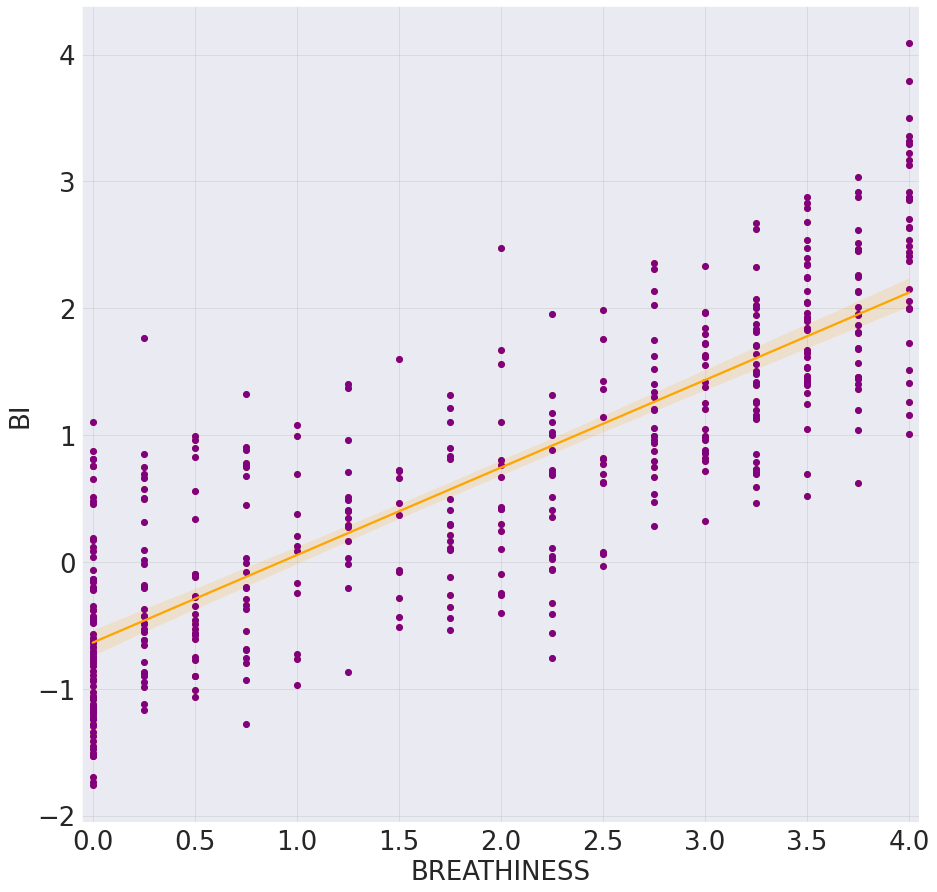

In [ ]:
from scipy import stats
dec = 4

print('___________________________________')
print('Pearson Correlation Coefficients')

# PITCH DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,3]

my_rho = stats.pearsonr(x, y)
print('DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('DIFS / BREATHINESS p = ', round(my_rho[1], dec))


# PITCH ABS DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,4]
my_rho = stats.pearsonr(x, y)
print('ABS DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABS DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH DIFFS MEL / BREATHINESS
x = COMP[:,5]
y = COMP[:,12]
my_rho = stats.pearsonr(x, y)
print('MEL DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('MEL DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP MIC / BREATHINESS
x = COMP[:,5]
y = COMP[:,6]
my_rho = stats.pearsonr(x, y)
print('CPP MIC / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP MIC / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP EGG / BREATHINESS
x = COMP[:,5]
y = COMP[:,7]
my_rho = stats.pearsonr(x, y)
print('CPP EGG / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP EGG / BREATHINESS p = ', round(my_rho[1], dec))

# DEGG OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,8]
my_rho = stats.pearsonr(x, y)
print('DEG OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('DEG OQ / BREATHINESS p = ', round(my_rho[1], dec))

# HOWARD OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,9]
my_rho = stats.pearsonr(x, y)
print('HOWARD OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('HOWARD OQ / BREATHINESS p = ', round(my_rho[1], dec))

# ABI / BREATHINESS
x = COMP[:,5]
y = COMP[:,13]
my_rho = stats.pearsonr(x, y)
print('ABI / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABI / BREATHINESS p = ', round(my_rho[1], dec))

# CDH / BREATHINESS
x = COMP[:,5]
y = COMP[:,14]
my_rho = stats.pearsonr(x, y)
print('CDH / BREATHINESS cor = ', round(my_rho[0], dec))
print('CDH / BREATHINESS p = ', round(my_rho[1], dec))

print('')
print('___________________________________')
print('')

print('___________________________________')
print('Spearman Correlation Coefficients')

# PITCH DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,3]
my_rho = stats.spearmanr(x, y)
#print('DIFS / BREATHINESS cor = ', my_rho)
print('DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH ABS DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,4]
my_rho = stats.spearmanr(x, y)
print('ABS DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABS DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH DIFFS MEL / BREATHINESS
x = COMP[:,5]
y = COMP[:,12]
my_rho = stats.spearmanr(x, y)
print('MEL DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('MEL DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP MIC / BREATHINESS
x = COMP[:,5]
y = COMP[:,6]
my_rho = stats.spearmanr(x, y)
print('CPP MIC / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP MIC / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP EGG / BREATHINESS
x = COMP[:,5]
y = COMP[:,7]
my_rho = stats.spearmanr(x, y)
print('CPP EGG / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP EGG / BREATHINESS p = ', round(my_rho[1], dec))

# DEGG OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,8]
my_rho = stats.spearmanr(x, y)
print('DEG OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('DEG OQ / BREATHINESS p = ', round(my_rho[1], dec))

# HOWARD OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,9]
my_rho = stats.spearmanr(x, y)
print('HOWARD OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('HOWARD OQ / BREATHINESS p = ', round(my_rho[1], dec))

# ABI / BREATHINESS
x = COMP[:,5]
y = COMP[:,13]
my_rho = stats.spearmanr(x, y)
print('ABI / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABI / BREATHINESS p = ', round(my_rho[1], dec))

# CDH / BREATHINESS
x = COMP[:,5]
y = COMP[:,14]
my_rho = stats.spearmanr(x, y)
print('CDH / BREATHINESS cor = ', round(my_rho[0], dec))
print('CDH / BREATHINESS p = ', round(my_rho[1], dec))

print('')
print('___________________________________')
print('')

RMEAN = np.round(MEAN, 4)
print(RMEAN)



plt.rcParams.update({'font.size': 26})
plt.rcParams.update({'font.family': 'STIX General'})
import seaborn as sns
xliml = -0.05
xlimr = 4.05

# PITCH ΒΙ / BREATHINESS
x = COMP[:,5]
y = COMP[:,14]
plt.figure(figsize=(15,15))
plt.plot(x, y, "o", color = 'purple')
sns.regplot(x, y, color = 'orange')
sns.set_style("darkgrid")
plt.grid(color = 'grey', linestyle = '-', alpha=0.3, linewidth = 0.5)
plt.xlim(xliml, xlimr)
plt.ylabel("ΒΙ")
plt.xlabel("BREATHINESS")
plt.show()

REGRESSION 2

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
LR = np.zeros((456, 4))
RR = np.zeros((456, 1))

for i in range (0, 456):
  LR[i][0]=CPP_EVAL[i]
  LR[i][1]=DOQ[i]
  LR[i][2]=HOQ[i]
  LR[i][3]=ABI[i]
  RR[i]=BR_EVAL[i]

In [ ]:
import numpy as np
import statsmodels.api as sm
def get_stats():
    x = LR
    y = RR
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.898
Model:                            OLS   Adj. R-squared (uncentered):              0.897
Method:                 Least Squares   F-statistic:                              992.8
Date:                Sun, 28 Nov 2021   Prob (F-statistic):                   2.72e-222
Time:                        11:04:26   Log-Likelihood:                         -516.28
No. Observations:                 456   AIC:                                      1041.
Df Residuals:                     452   BIC:                                      1057.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression
x = LR
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(LR, RR)

print(linear_model.coef_)

[[-0.06959419 -3.26429585  8.27435347  0.2633933 ]]


In [ ]:
dec = 4
BBI = np.zeros((456,1))

for i in range (0,456):
  BBI[i] = (-0.06959419 * COMP[i][6]) +  (-3.26429585 * COMP[i][8]) + (8.27435347 * COMP[i][9]) + (0.2633933 * COMP[i][13]) 

print(BBI.shape)

x = COMP[:,5]
y = BBI
my_rho = stats.spearmanr(x, y)
print('CDH+ABI / BREATHINESS cor = ', round(my_rho[0], dec))
print('CDH+ABI / BREATHINESS p = ', round(my_rho[1], dec))

(456, 1)
CDH+ABI / BREATHINESS cor =  0.87
CDH+ABI / BREATHINESS p =  0.0


In [ ]:
COMP = np.zeros((456, 17))
for i in range (0, 456):
  COMP[i][0]=i
  COMP[i][1]=MIC_PITCH_NP[i]
  COMP[i][2]=EGG_PITCH_NP[i]
  COMP[i][3]=SUB_PITCH_NP[i]
  COMP[i][4]=abs(SUB_PITCH_NP[i])
  COMP[i][5]=BR_EVAL[i]
  COMP[i][6]=CPP_EVAL[i]
  COMP[i][7]=CPP_EGG_EVAL[i]
  COMP[i][8]=DOQ[i]
  COMP[i][9]=HOQ[i]
  COMP[i][10]=MEL_MIC_PITCH_NP[i]
  COMP[i][11]=MEL_EGG_PITCH_NP[i]
  COMP[i][12]=MEL_SUB_PITCH_NP[i]
  COMP[i][13]=ABI[i]
  COMP[i][14]=BI[i]
  COMP[i][15]=BBI[i]
  COMP[i][16]= abs(MEL_SUB_PITCH_NP[i])
print(COMP)
print(COMP.shape)

[[   0.          181.8027      181.7826        0.0201        0.0201
     0.75         19.49377103   20.53599861    0.52700829    0.57699113
   260.21077577  260.1850864     0.0257        0.61562332   -0.20973342
     1.8594154     0.0257    ]
 [   1.          180.9253      180.9227        0.0026        0.0026
     0.5          20.82980252   20.63491329    0.47009544    0.54869619
   259.08884444  259.08551816    0.0033       -0.05607088   -0.57363176
     1.54117375    0.0033    ]
 [   2.          180.2598      180.2467        0.0131        0.0131
     0.25         21.11145121   20.45966146    0.44617299    0.54270393
   258.23712416  258.22035205    0.0168       -0.08854674   -0.61222453
     1.54152654    0.0168    ]
 [   3.          180.0371      180.0327        0.0044        0.0044
     0.5          21.48698088   20.54878737    0.4385496     0.54864534
   257.95196442  257.94632964    0.0056        0.26010991   -0.60854266
     1.68127199    0.0056    ]
 [   4.          179.8933   

___________________________________
Pearson Correlation Coefficients
DIFS / BREATHINESS cor =  -0.0606
DIFS / BREATHINESS p =  0.1966
ABS DIFS / BREATHINESS cor =  0.202
ABS DIFS / BREATHINESS p =  0.0
MEL DIFS / BREATHINESS cor =  -0.0494
MEL DIFS / BREATHINESS p =  0.2927
CPP MIC / BREATHINESS cor =  -0.7655
CPP MIC / BREATHINESS p =  0.0
CPP EGG / BREATHINESS cor =  -0.4701
CPP EGG / BREATHINESS p =  0.0
DEG OQ / BREATHINESS cor =  0.5516
DEG OQ / BREATHINESS p =  0.0
HOWARD OQ / BREATHINESS cor =  0.6423
HOWARD OQ / BREATHINESS p =  0.0
ABI / BREATHINESS cor =  0.8107
ABI / BREATHINESS p =  0.0
CDH / BREATHINESS cor =  0.8308
CDH / BREATHINESS p =  0.0
CDH+ABI / BREATHINESS cor =  0.8534
CDH+ABI / BREATHINESS p =  0.0

___________________________________

___________________________________
Spearman Correlation Coefficients
DIFS / BREATHINESS cor =  -0.1436
DIFS / BREATHINESS p =  0.0021
ABS DIFS / BREATHINESS cor =  0.4405
ABS DIFS / BREATHINESS p =  0.0
MEL DIFS / BREATHINESS cor

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


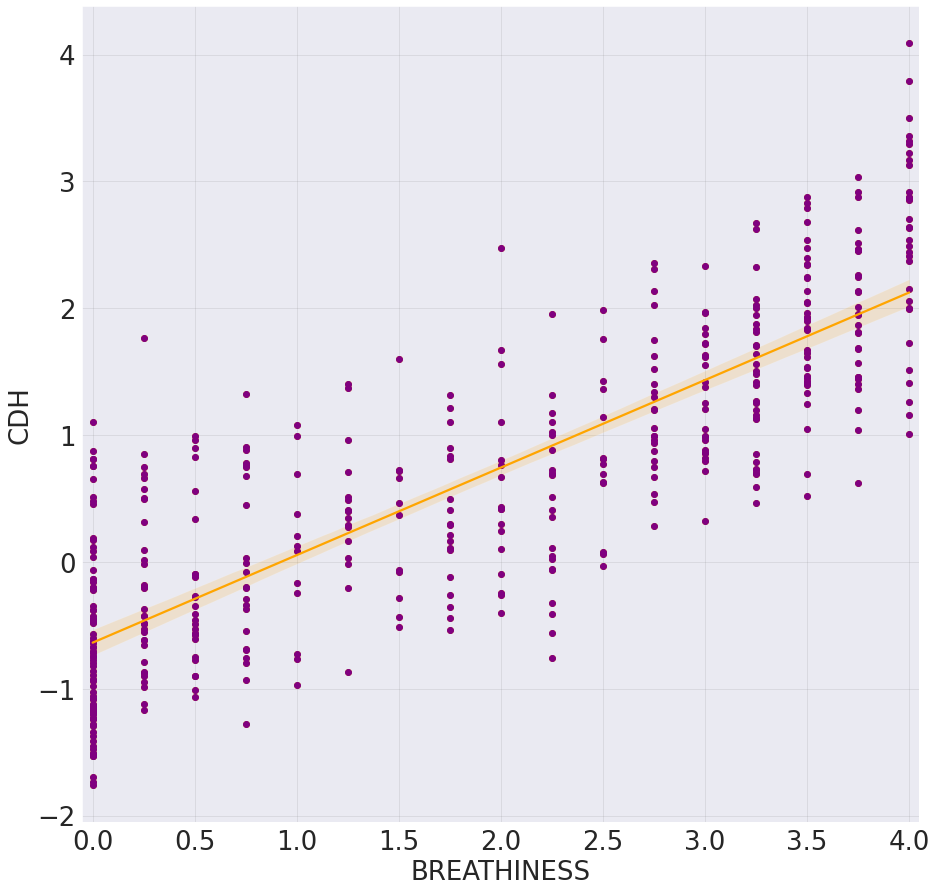

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


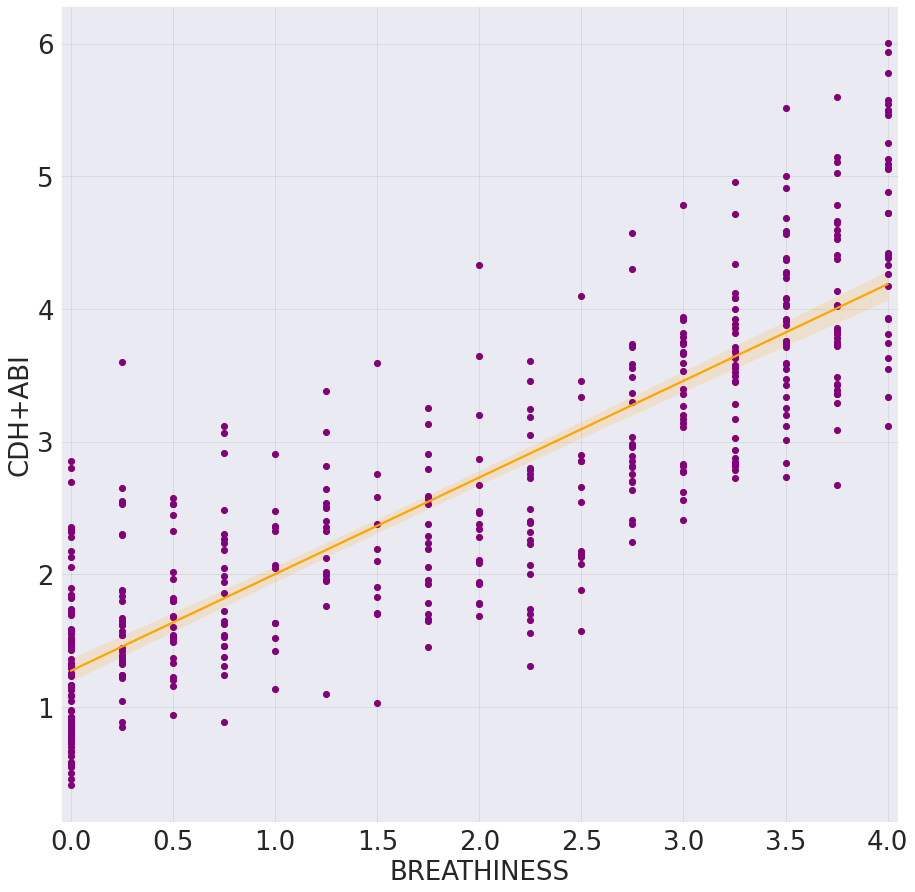

In [ ]:
from scipy import stats
dec = 4

print('___________________________________')
print('Pearson Correlation Coefficients')

# PITCH DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,3]

my_rho = stats.pearsonr(x, y)
print('DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('DIFS / BREATHINESS p = ', round(my_rho[1], dec))


# PITCH ABS DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,4]
my_rho = stats.pearsonr(x, y)
print('ABS DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABS DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH DIFFS MEL / BREATHINESS
x = COMP[:,5]
y = COMP[:,12]
my_rho = stats.pearsonr(x, y)
print('MEL DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('MEL DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP MIC / BREATHINESS
x = COMP[:,5]
y = COMP[:,6]
my_rho = stats.pearsonr(x, y)
print('CPP MIC / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP MIC / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP EGG / BREATHINESS
x = COMP[:,5]
y = COMP[:,7]
my_rho = stats.pearsonr(x, y)
print('CPP EGG / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP EGG / BREATHINESS p = ', round(my_rho[1], dec))

# DEGG OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,8]
my_rho = stats.pearsonr(x, y)
print('DEG OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('DEG OQ / BREATHINESS p = ', round(my_rho[1], dec))

# HOWARD OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,9]
my_rho = stats.pearsonr(x, y)
print('HOWARD OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('HOWARD OQ / BREATHINESS p = ', round(my_rho[1], dec))

# ABI / BREATHINESS
x = COMP[:,5]
y = COMP[:,13]
my_rho = stats.pearsonr(x, y)
print('ABI / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABI / BREATHINESS p = ', round(my_rho[1], dec))

# CDH / BREATHINESS
x = COMP[:,5]
y = COMP[:,14]
my_rho = stats.pearsonr(x, y)
print('CDH / BREATHINESS cor = ', round(my_rho[0], dec))
print('CDH / BREATHINESS p = ', round(my_rho[1], dec))

# CDHA / BREATHINESS
x = COMP[:,5]
y = COMP[:,15]
my_rho = stats.pearsonr(x, y)
print('CDH+ABI / BREATHINESS cor = ', round(my_rho[0], dec))
print('CDH+ABI / BREATHINESS p = ', round(my_rho[1], dec))

print('')
print('___________________________________')
print('')

print('___________________________________')
print('Spearman Correlation Coefficients')

# PITCH DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,3]
my_rho = stats.spearmanr(x, y)
#print('DIFS / BREATHINESS cor = ', my_rho)
print('DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH ABS DIFS / BREATHINESS
x = COMP[:,5]
y = COMP[:,4]
my_rho = stats.spearmanr(x, y)
print('ABS DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABS DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH DIFFS MEL / BREATHINESS
x = COMP[:,5]
y = COMP[:,12]
my_rho = stats.spearmanr(x, y)
print('MEL DIFS / BREATHINESS cor = ', round(my_rho[0], dec))
print('MEL DIFS / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP MIC / BREATHINESS
x = COMP[:,5]
y = COMP[:,6]
my_rho = stats.spearmanr(x, y)
print('CPP MIC / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP MIC / BREATHINESS p = ', round(my_rho[1], dec))

# PITCH CPP EGG / BREATHINESS
x = COMP[:,5]
y = COMP[:,7]
my_rho = stats.spearmanr(x, y)
print('CPP EGG / BREATHINESS cor = ', round(my_rho[0], dec))
print('CPP EGG / BREATHINESS p = ', round(my_rho[1], dec))

# DEGG OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,8]
my_rho = stats.spearmanr(x, y)
print('DEG OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('DEG OQ / BREATHINESS p = ', round(my_rho[1], dec))

# HOWARD OQ / BREATHINESS
x = COMP[:,5]
y = COMP[:,9]
my_rho = stats.spearmanr(x, y)
print('HOWARD OQ / BREATHINESS cor = ', round(my_rho[0], dec))
print('HOWARD OQ / BREATHINESS p = ', round(my_rho[1], dec))

# ABI / BREATHINESS
x = COMP[:,5]
y = COMP[:,13]
my_rho = stats.spearmanr(x, y)
print('ABI / BREATHINESS cor = ', round(my_rho[0], dec))
print('ABI / BREATHINESS p = ', round(my_rho[1], dec))

# CDH / BREATHINESS
x = COMP[:,5]
y = COMP[:,14]
my_rho = stats.spearmanr(x, y)
print('CDH / BREATHINESS cor = ', round(my_rho[0], dec))
print('CDH / BREATHINESS p = ', round(my_rho[1], dec))

# CDH+ABI / BREATHINESS
x = COMP[:,5]
y = COMP[:,15]
my_rho = stats.spearmanr(x, y)
print('CDH+ABI / BREATHINESS cor = ', round(my_rho[0], dec))
print('CDH+ABI / BREATHINESS p = ', round(my_rho[1], dec))

print('')
print('___________________________________')
print('')


l = COMP.shape[0]
c = COMP.shape[1]
SUMS = np.zeros((5, c))
count0 = 0
count1 = 0
count2 = 0
count3 = 0
count4 = 0

for i in range (0, l):
    if (COMP[i][5] < 0.75):
      SUMS[0][0] = SUMS[0][0] + 1
      SUMS[0][1:] = SUMS[0][1:] + COMP[i][1:]
    elif (COMP[i][5] <= 1.5):
      SUMS[1][0] = SUMS[1][0] + 1
      SUMS[1][1:] = SUMS[1][1:] + COMP[i][1:]
    elif (COMP[i][5] <= 2.25):
      SUMS[2][0] = SUMS[2][0] + 1
      SUMS[2][1:] = SUMS[2][1:] + COMP[i][1:]
    elif (COMP[i][5] <= 3.25):
      SUMS[3][0] = SUMS[3][0] + 1
      SUMS[3][1:] = SUMS[3][1:] + COMP[i][1:]
    else:
      SUMS[4][0] = SUMS[4][0] + 1
      SUMS[4][1:] = SUMS[4][1:] + COMP[i][1:]

print('SUM VALUES')
print(SUMS)
print('SAMLES: ', l)

print('')
print('___________________________________')
print('')

print('MEAN VALUES')
MEAN = np.zeros((5, c))
for m in range (1, c):
  MEAN[0][m] = SUMS[0][m]/SUMS[0][0]
  MEAN[1][m] = SUMS[1][m]/SUMS[1][0]
  MEAN[2][m] = SUMS[2][m]/SUMS[2][0]
  MEAN[3][m] = SUMS[3][m]/SUMS[3][0]
  MEAN[4][m] = SUMS[4][m]/SUMS[4][0]

RMEAN = np.round(MEAN, 4)
print(RMEAN)



plt.rcParams.update({'font.size': 26})
plt.rcParams.update({'font.family': 'STIX General'})
import seaborn as sns
xliml = -0.05
xlimr = 4.05

# PITCH CDH / BREATHINESS
x = COMP[:,5]
y = COMP[:,14]
plt.figure(figsize=(15,15))
plt.plot(x, y, "o", color = 'purple')
sns.regplot(x, y, color = 'orange')
sns.set_style("darkgrid")
plt.grid(color = 'grey', linestyle = '-', alpha=0.3, linewidth = 0.5)
plt.xlim(xliml, xlimr)
plt.ylabel("CDH")
plt.xlabel("BREATHINESS")
plt.show()


# PITCH CDH+ABI / BREATHINESS
x = COMP[:,5]
y = COMP[:,15]
plt.figure(figsize=(15,15))
plt.plot(x, y, "o", color = 'purple')
sns.regplot(x, y, color = 'orange')
sns.set_style("darkgrid")
plt.grid(color = 'grey', linestyle = '-', alpha=0.3, linewidth = 0.5)
plt.xlim(xliml, xlimr)
plt.ylabel("CDH+ABI")
plt.xlabel("BREATHINESS")
plt.show()